In [1]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 885.6 kB/s eta

In [2]:
import tensorflow as tf
import gradio as gr
import numpy as np
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
import joblib

In [3]:
from google.colab import drive

In [4]:
# Mount Google Drive
drive.mount('/content/drive')

IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 5

Mounted at /content/drive


In [7]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    '/content/drive/My Drive/PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)


Found 3000 files belonging to 3 classes.


In [8]:
# Access class names
class_names = dataset.class_names
print(class_names)

['Tomato_Early_blight', 'Tomato_Late_blight', 'Tomato_healthy']


Image Batch size:  (32, 256, 256, 3)
Labels in one batch size: 
 [1 1 0 1 1 1 1 0 2 1 0 0 0 1 0 2 2 0 0 2 0 1 1 0 1 2 0 0 0 1 1 2]


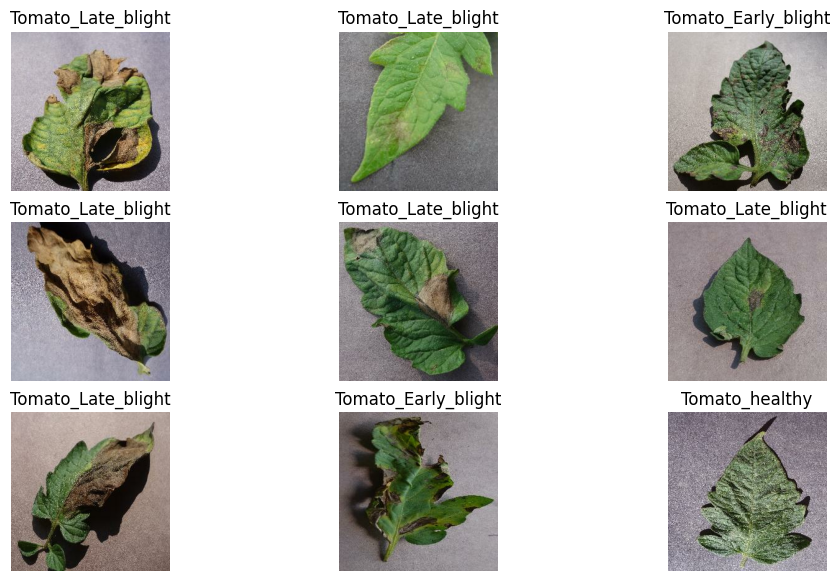

In [9]:
# Reading image
plt.figure(figsize=(12, 7))
for image_batch, label_batch in dataset.take(1):
    print('Image Batch size: ', image_batch.shape)
    print('Labels in one batch size: \n', label_batch.numpy())

    for i in range(9):
        sub = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')

In [10]:
# Data Preprocessing and Augmentation
def get_partitions_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    assert (train_split + val_split + test_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=0)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [11]:
# Using cache and prefetch
train_ds, val_ds, test_ds = get_partitions_dataset(dataset)

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
# Resize and rescale
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0 / 255)
])

In [13]:
# Data Augmentation
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.1)
])

In [14]:
# Model creation and training
# Model Architecture
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
base_model.trainable = False

cnn_model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

cnn_model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [15]:
# Training
history = cnn_model.fit(train_ds,
                        batch_size=BATCH_SIZE,
                        epochs=EPOCHS,
                        validation_data=val_ds,
                        verbose=1)

Epoch 1/5
75/75 [==============================] - 2660s 32s/step - loss: 1.2226 - accuracy: 0.7186 - val_loss: 0.3786 - val_accuracy: 0.8194
Epoch 2/5
75/75 [==============================] - 2340s 31s/step - loss: 0.4122 - accuracy: 0.8324 - val_loss: 0.3141 - val_accuracy: 0.8576
Epoch 3/5
75/75 [==============================] - 2364s 32s/step - loss: 0.2953 - accuracy: 0.8742 - val_loss: 0.3029 - val_accuracy: 0.8542
Epoch 4/5
75/75 [==============================] - 2320s 31s/step - loss: 0.3456 - accuracy: 0.8558 - val_loss: 0.2487 - val_accuracy: 0.8993
Epoch 5/5
75/75 [==============================] - 2334s 31s/step - loss: 0.2833 - accuracy: 0.8863 - val_loss: 0.2810 - val_accuracy: 0.8993


In [16]:
# Extract features for SVM
def extract_features(dataset):
    features = []
    labels = []
    for image_batch, label_batch in dataset:
        features.append(cnn_model.predict(image_batch))
        labels.extend(label_batch.numpy())
    features = np.vstack(features)
    labels = np.array(labels)
    return features, labels

train_features, train_labels = extract_features(train_ds)
val_features, val_labels = extract_features(val_ds)
test_features, test_labels = extract_features(test_ds)

1/1 [==============================] - 28s 28s/step


In [17]:
# Train SVM
svm_classifier = make_pipeline(StandardScaler(), svm.SVC(kernel='linear'))
svm_classifier.fit(train_features, train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='linear'))])

In [18]:
# Evaluate SVM
val_predictions = svm_classifier.predict(val_features)
print("Validation Accuracy:", accuracy_score(val_labels, val_predictions))

test_predictions = svm_classifier.predict(test_features)
print("Test Accuracy:", accuracy_score(test_labels, test_predictions))

Validation Accuracy: 0.9201388888888888
Test Accuracy: 0.9038461538461539


In [19]:
# Save the CNN and SVM models
cnn_model.save('/content/drive/My Drive/Tomato_CNN.h5')
joblib.dump(svm_classifier, '/content/drive/My Drive/Tomato_SVM.pkl')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


['/content/drive/My Drive/Tomato_SVM.pkl']

In [23]:
# Gradio Interface
def predict(image):
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = tf.expand_dims(image, axis=0) / 255.0
    features = cnn_model.predict(image)
    prediction = svm_classifier.predict(features)
    return class_names[prediction[0]]

interface = gr.Interface(fn=predict,
                         inputs=gr.Image(type="numpy"),
                         outputs=gr.Label())
interface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://533ec065875f077747.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
